In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 50 kB/s 
     |████████████████████████████████| 199 kB 67.0 MB/s 


In [2]:
from pyspark.sql import SparkSession
sc = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
data = sc.read \
  .option('header', 'True')\
  .option('inferSchema', 'True')\
  .option('sep', ',')\
  .csv('/content/drive/MyDrive/data.csv')

*  **drop rows with missing values**
*   **drop duplicate rows**



In [14]:
data = data.na.drop()
df = data.distinct()

# shuffling data and sampling 20 percent of data

In [15]:
from pyspark.sql.functions import rand 
shuffledDF = data.orderBy(rand())

new_df = shuffledDF.sample(fraction=0.2)

# pick Longitude and Latitude features
unimportant_features = ['Date/Time', 'Base']
new_df = new_df.drop(*tuple(unimportant_features))

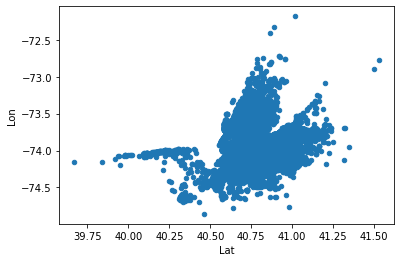

In [16]:
new_df.toPandas().plot.scatter(x='Lat', y='Lon')  

# vectorize latitude and longitude features

In [17]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=[
'Lat', 'Lon'], outputCol='features')

assembled_data=assemble.transform(new_df)
assembled_data.show(2)

+-------+--------+------------------+
|    Lat|     Lon|          features|
+-------+--------+------------------+
|40.7257|-73.9777|[40.7257,-73.9777]|
|40.7681|-73.9214|[40.7681,-73.9214]|
+-------+--------+------------------+
only showing top 2 rows



# standardize data

In [18]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+--------+------------------+--------------------+
|    Lat|     Lon|          features|        standardized|
+-------+--------+------------------+--------------------+
|40.7257|-73.9777|[40.7257,-73.9777]|[1019.60540278154...|
|40.7681|-73.9214|[40.7681,-73.9214]|[1020.66692582664...|
+-------+--------+------------------+--------------------+
only showing top 2 rows



# **K-Means**

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
SSE = []

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,20):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    # print("Silhouette Score:",score)

    cost = KMeans_fit.summary.trainingCost
    SSE.append(cost)
    # print("Sum of Squared Errors = " + str(cost))


# find best K using silhouette_score

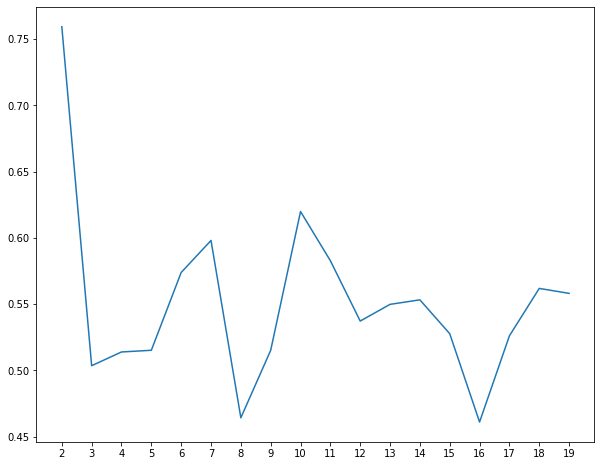

In [26]:
x=[]
for i in range(2,20):
  x.append(i)

plt.figure(figsize=(10, 8))
plt.xticks(x)
plt.plot(x, silhouette_score)

# find best K using elbow method

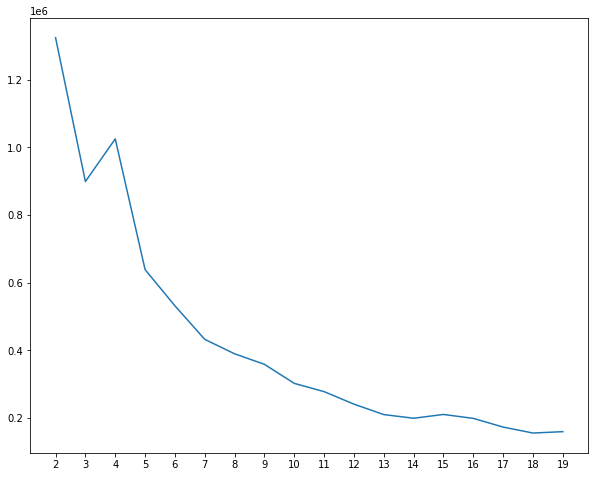

In [27]:
x=[]
for i in range(2,20):
  x.append(i)

plt.figure(figsize=(10, 8))
plt.xticks(x)
plt.plot(x, SSE)

# clustering with k = 10

In [28]:
kmeans = KMeans(featuresCol='standardized', k=10)
KMeans_fit=kmeans.fit(data_scale_output)
c_pred = KMeans_fit.transform(data_scale_output)
centers = KMeans_fit.clusterCenters()

save model

In [29]:
model = KMeans_fit
model_path = "/content/drive/MyDrive/kmeans_model"
model.save(model_path)

In [30]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

lat_list = []
for each in centers:
  lat_list.append(each[0])

lon_list = []  
for each in centers:
  lon_list.append(each[1])


transformed = c_pred.select('Lat', 'Lon', 'prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)
pddf_pred = df_pred.toPandas()

# plt.scatter(lat_list, lon_list, marker='x', c='black')

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [36]:
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt

sqlContext = SQLContext(sc)

transformed = c_pred.select('Lat', 'Lon', 'prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)
pddf_pred = df_pred.toPandas()

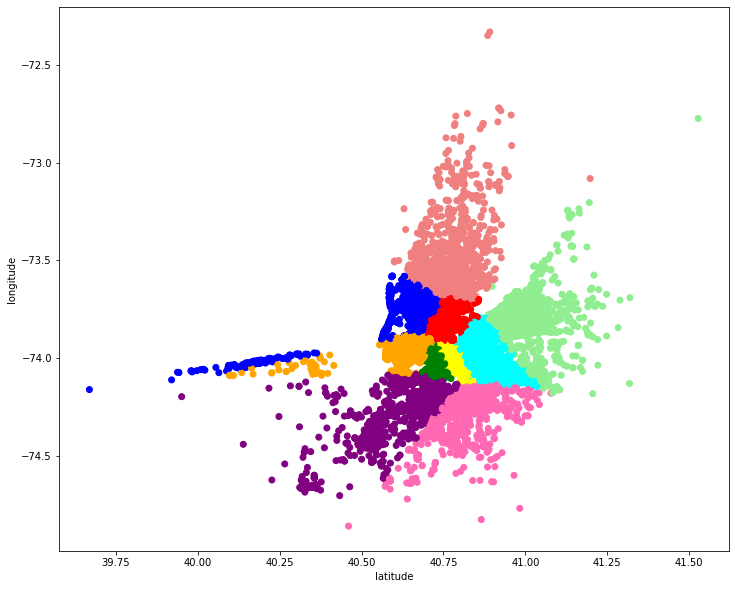

In [35]:
import numpy as np

colors=("red","blue","green", "yellow","hotpink","purple","orange","aqua","lightgreen","lightcoral")

thowdee = plt.figure(figsize=(12,10)).gca()
thowdee.scatter(pddf_pred.Lat, pddf_pred.Lon, c= np.take(colors, pddf_pred.prediction))
thowdee.set_xlabel('latitude')
thowdee.set_ylabel('longitude')
# thowdee.scatter(lat_list, lon_list, marker='x', c='black')
plt.show()